# Making Your Life Easier
The last example was great but imagine a scenario where you have 12 (or 120!) variables you want to solve for. Typing out definitions for each of the variables and constraints individually would use up an enormous amount of time! Computers are supposed to make our lives **easier**, darnit!

First off, let's do our usual initialization:

In [1]:
from gurobipy import *
import matplotlib.pyplot as pyplot

m = Model()

Academic license - for non-commercial use only


---
## What if I told you...
there was an easier way?

*The following code is just a bit of fun -- feel free to pay as little or as much attention to it as you want.*

In [2]:
# Code gratefully stolen/adapted from
# https://www.hackerearth.com/practice/notes/beautiful-python-a-simple-ascii-art-generator-from-images/

from PIL import Image

ASCII_CHARS = [ '#', '?', '%', '.', 'S', '+', '.', '*', ':', ',', '@']

def scale_image(image, new_width=100):
    """Resizes an image preserving the aspect ratio.
    """
    (original_width, original_height) = image.size
    aspect_ratio = original_height/float(original_width)
    new_height = int(aspect_ratio * new_width)

    new_image = image.resize((new_width, new_height))
    return new_image

def convert_to_grayscale(image):
    return image.convert('L')

def map_pixels_to_ascii_chars(image, range_width=25):
    """Maps each pixel to an ascii char based on the range
    in which it lies.

    0-255 is divided into 11 ranges of 25 pixels each.
    """

    pixels_in_image = list(image.getdata())
    pixels_to_chars = [ASCII_CHARS[int(pixel_value/range_width)] for pixel_value in
            pixels_in_image]

    return "".join(pixels_to_chars)

def convert_image_to_ascii(image, new_width=100):
    image = scale_image(image)
    image = convert_to_grayscale(image)

    pixels_to_chars = map_pixels_to_ascii_chars(image)
    len_pixels_to_chars = len(pixels_to_chars)

    image_ascii = [pixels_to_chars[index: index + new_width] for index in
            range(0, len_pixels_to_chars, new_width)]

    return "\n".join(image_ascii)

def handle_image_conversion(image_filepath):
    image = Image.open(image_filepath)

    image_ascii = convert_image_to_ascii(image)
    print(image_ascii)

handle_image_conversion("morph.png")

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@,:..?%??????%.+::,,@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@S####################??%*@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@?##?############?##########?#??+@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@,?####?#????##????????#???????##?#???*@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@.####??#%????##????##???#?????????#####?%,@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@,?#####?%?%?????%%?%%?%%???%??%?%?%?%#?#??#??+@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@+#####??#%%%%%?..?%...%%.?%%%.%.%?????.?#??#####%:@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@S##???????????.%%%%..+.%..%...%%%%%?.%%%%%?#??#####?*@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@+###????%?%%%.%%....S..S.SSS.SSSS%.S%S.%.?%%???####?#??,@@@@@@@@@@

## The problem
This time we will be solving one of the problems you saw earlier in the course: the so-called **Model 3** problem:

---

The Northeast Tollway out of Chicago has a toll plaza with the following staffing demands during each 24-hour period: 

| Hours | Collectors Needed |
|---|---|
| 12-6 a.m. | 2 |
| 6-10 a.m. | 8 |
| 10 a.m. to noon | 4 |
| noon to 4 p.m. | 3 |
| 4-6 p.m. | 6 |
| 6-10 p.m. | 5 |
| 10 p.m. to midnight | 3 |

Each collector works 4 hours, is off one hour, and then works another 4 hours. A collector can be started at any hour. Assume the objective is to minimize the number of collectors hired, formulate **and solve** the appropriate LP. 

---

## The data
The first thing to do is to declare some data structures that will contain our data. In a real-world situation we would have already collected some data and have it available to us (e.g. in a programmatically-generated data file or even better in a database).

For this example we will just assume we've already extracted our data from our data source and have it ready to use.

In [3]:
# We will use the convention that 
#     0  =>  midnight
#     1  =>  1 a.m.
#     ...
#     12 =>  noon
#     ...
#     23 =>  11 p.m.
# Setting this as a variable at the beginning makes it easier to change later if we want
# to use a different number of possible starting times
hours = range(24)

# A function that returns the employees needed for a given hour.
# Also good practice in using if/elif/else! :)
def need(x):
    if x < 6:
        return 2
    elif x < 10:
        return 8
    elif x < 12:
        return 4
    elif x < 16:
        return 3
    elif x < 18:
        return 6
    elif x < 22:
        return 5
    else:
        return 3

# This creates a dictionary that contains the number of employees we need at any given time
needed = { hr : need(hr) for hr in hours }

# Usage: (number of employees needed at 2pm)
print(needed[14])
# Usage: Pretty printing
print("At hour %d we will need %d people on-staff." % (4, needed[4]))

3
At hour 4 we will need 2 people on-staff.


In [4]:
# This array will be useful in setting up our constraints. 
# The (i,j)th entry is 0 or 1 depending on whether or not an employee
# who started at hour i is still on-duty during hour j.

# This function computes whether someone who started at i is around at j.
def isAround(i,j):
    if j in [(i+k) % len(hours) for k in [0,1,2,3,5,6,7,8]]:
        return 1
    return 0

# An array of dictionaries
# onDuty[j] is a dictionary telling us whether i is working at hour j.
onDuty = [{i : isAround(i,j) for i in hours} for j in hours]

# Usage: Is someone who started at 2am around at 7am?
print(onDuty[7][2])

# Print it out so you can see 
for i in hours:
    print([onDuty[j][i] for j in hours])

1
[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

---
## Adding Variables
Now that we have our data we want to add our (twelve) variables programmatically. Here's how we do that:

In [5]:
employeesStarting = m.addVars(hours, vtype=GRB.INTEGER, name="emloyeesStarting")

That's it!

---
## Setting constraints
Then we have to set our constraints -- we want to ensure that each of the hours is amply-staffed.

In [6]:
# Add constraints
m.addConstrs((employeesStarting.prod(onDuty[j]) >= needed[j] for j in hours), "min")
# Update model
m.update()

---
## Set the objective and run!

In [7]:
m.setObjective(employeesStarting.sum(), GRB.MINIMIZE)
m.optimize()

Optimize a model with 24 rows, 24 columns and 192 nonzeros
Variable types: 0 continuous, 24 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 8e+00]
Found heuristic solution: objective 27.0000000
Presolve time: 0.00s
Presolved: 24 rows, 24 columns, 192 nonzeros
Variable types: 0 continuous, 24 integer (0 binary)

Root relaxation: objective 1.575000e+01, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.75000    0    5   27.00000   15.75000  41.7%     -    0s
H    0     0                      16.0000000   15.75000  1.56%     -    0s

Explored 1 nodes (24 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 16 27 

Optimal solution found (tolerance 1.00e-04)
Best objective 1

---
## Examine our solution

Optimal Solution Found!

We need 16 employees in total.

Hour:	 Employees Needed:
0	 0
1	 5
2	 1
3	 1
4	 1
5	 1
6	 0
7	 0
8	 0
9	 0
10	 1
11	 0
12	 0
13	 1
14	 2
15	 1
16	 1
17	 1
18	 0
19	 0
20	 0
21	 0
22	 0
23	 0


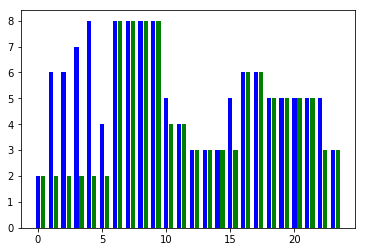

In [8]:
# It's a good practice to check whether the solution is an optimal one
if m.status == GRB.Status.OPTIMAL:
    print('Optimal Solution Found!\n')
    # Gets the final values from our variables
    solution = m.getAttr('x', employeesStarting)
    
    # This value should be minimized
    print('We need %d employees in total.\n' % m.getAttr('ObjVal'))
        
    # Print our solution
    print('Hour:\t Employees Needed:')
    for h in hours:
        print('%d\t %d' % (h, solution[h]))
    
    # Create a bar chart to demonstrate we have satisfied our constraints
    # Y-values
    data = [0 for h in hours]
    for h in hours:
        for j in hours:
            if onDuty[h][j]:
                data[h] += solution[j]
    neededList = [needed[i] for i in hours]
    # X-values
    x1 = range(len(data))
    x2 = [i+0.4 for i in x1]
    # Width of bar
    w = 1/3
    # Tell the plotter we want to add several graphs to the same plot
    ax = pyplot.subplot(111)
    ax.bar(x1, data,width=w,color='b',align='center')
    ax.bar(x2, neededList,width=w,color='g',align='center')
    pyplot.show()
else:
    print("No optimal solution found!")
